# Regression Against Time

## The Formation Process of Winners and Losers in Momentum Investing
(https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2610571)

> **p. 3**: Intermediate-term (3–12 months) momentum has been documented by Jegadeesh
and Titman (1993, 2001, hereafter JT), while short-term (weekly) and long-term (3–5
years) reversals have been documented by Lehmann (1990) and Jegadeesh (1990) and
by DeBondt and Thaler (1985), respectively. Various models and theories have been
proposed to explain the coexistence of intermediate-term momentum and long-term
reversal. However, most studies have focused primarily on which stocks are winners
or losers; they have paid little attention to how those stocks become winners or losers.
This paper develops a model to analyze whether the movement of historical prices is
related to future expected returns.

> **p. 4**: This paper captures the idea that past returns and the formation process of past
returns have a joint effect on future expected returns. We argue that how one stock
becomes a winner or loser—that is, the movement of historical prices—plays an
important role in momentum investing. Using a polynomial quadratic model to
approximate the nonlinear pattern of historical prices, the model shows that as long as
two stocks share the same return over the past n-month, the future expected return of
the stock whose historical prices are convex shaped is not lower than one whose
historical prices are concave shaped. In other words, when there are two winner (or
loser) stocks, the one with convex-shaped historical prices will possess higher future
expected returns than the one with concave-shaped historical prices.

> **p. 4**: To test the model empirically, we regress previous daily prices in the ranking
period on an ordinal time variable and the square of the ordinal time variable for each
stock. The coefficient of the square of the ordinal time variable is denoted as $\gamma$.

## Install packages

In [1]:
import sys

In [2]:
#!{sys.executable} -m pip install -r requirements.txt

In [3]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import os
import quiz_helper
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

### data bundle

In [5]:
import os
import quiz_helper
from zipline.data import bundles

In [6]:
os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..','data','module_4_quizzes_eod')
ingest_func = bundles.csvdir.csvdir_equities(['daily'], quiz_helper.EOD_BUNDLE_NAME)
bundles.register(quiz_helper.EOD_BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


### Build pipeline engine

In [7]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar

universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(quiz_helper.EOD_BUNDLE_NAME)
engine = quiz_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Data¶
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [8]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

# Get Returns data

In [9]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

## Get pricing data helper function

In [10]:
from quiz_helper import get_pricing

## get pricing data into a dataframe

In [11]:
returns_df = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0) #convert prices into returns

returns_df

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.000000,0.001994,0.004165,0.001648,-0.007127,-0.005818,...,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.000000,0.012457,-0.000181,-0.010458,0.000000
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.000000,-0.005714,-0.008896,-0.008854,0.028714,0.002926,...,0.000947,0.007814,-0.006081,0.010466,0.009733,0.000000,0.001440,0.007784,-0.017945,0.000000
2011-01-11 00:00:00+00:00,-0.001886,-0.043644,-0.005927,-0.002367,0.000000,0.009783,-0.002067,0.013717,0.000607,0.008753,...,0.001314,0.010179,0.007442,0.007351,0.006116,0.000000,-0.006470,0.035676,0.007467,0.000000
2011-01-12 00:00:00+00:00,0.017254,-0.008237,0.013387,0.008133,0.000000,-0.005979,-0.001011,0.022969,0.017950,0.000257,...,0.004986,0.015666,0.011763,0.027182,0.004386,0.000000,0.002631,0.014741,-0.011903,0.000000
2011-01-13 00:00:00+00:00,-0.004559,0.000955,0.003031,0.003657,0.000000,0.014925,-0.004451,-0.000400,-0.005719,-0.005012,...,0.030499,-0.003217,0.001694,0.000547,-0.018235,0.000000,-0.005084,-0.004665,-0.009178,0.000000
2011-01-14 00:00:00+00:00,0.003439,-0.009156,0.003022,0.008106,0.000000,0.001395,-0.010111,0.002590,0.012283,0.019827,...,0.026607,0.025894,0.014743,-0.000287,0.026494,0.000000,-0.021661,0.005949,0.033177,0.000000
2011-01-18 00:00:00+00:00,0.034254,-0.062085,-0.004286,-0.022474,0.000000,0.020889,0.006621,0.006998,0.011542,0.032645,...,0.001678,0.002501,0.011163,0.011589,0.006044,0.000000,0.029453,0.006998,-0.008534,0.000000
2011-01-19 00:00:00+00:00,-0.010224,-0.008929,0.008754,-0.005314,0.000000,-0.017144,0.002753,-0.002962,-0.007899,-0.020575,...,-0.014834,-0.023590,-0.005968,-0.019899,-0.012847,0.000000,0.000818,-0.004098,-0.018433,0.000000
2011-01-20 00:00:00+00:00,-0.008496,0.021953,-0.004732,-0.018189,0.000000,0.004794,0.013322,0.018713,-0.012386,-0.002818,...,-0.024512,0.007744,-0.006261,-0.000841,-0.033798,0.000000,-0.013182,-0.001612,-0.007972,0.000000
2011-01-21 00:00:00+00:00,0.007873,-0.041038,0.005544,-0.017911,0.000000,0.010642,-0.000853,-0.001952,-0.006569,-0.004113,...,0.000000,0.000615,0.015825,-0.003048,-0.000872,0.000000,-0.007590,0.009325,0.024020,0.000000


## Sector data helper function
We'll create an object for you, which defines a sector for each stock.  The sectors are represented by integers.  We inherit from the Classifier class.  [Documentation for Classifier](https://www.quantopian.com/posts/pipeline-classifiers-are-here), and the [source code for Classifier](https://github.com/quantopian/zipline/blob/master/zipline/pipeline/classifiers/classifier.py)

In [12]:
from zipline.pipeline.classifiers import Classifier
from zipline.utils.numpy_utils import int64_dtype
class Sector(Classifier):
    dtype = int64_dtype
    window_length = 0
    inputs = ()
    missing_value = -1

    def __init__(self):
        self.data = np.load('../data/project_4_sector/data.npy')

    def _compute(self, arrays, dates, assets, mask):
        return np.where(
            mask,
            self.data[assets],
            self.missing_value,
        )

In [13]:
sector = Sector()

## We'll use 2 years of data to calculate the factor

**Note:** Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open.

In [14]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
factor_start_date

Timestamp('2014-01-03 00:00:00+0000', tz='UTC')

## describing price over time with a curve

To describe price over time, we'll use integers that increment each day as the independent variable.  We'll use price as the dependent variable.  Let's practice how to regress the stock price against time and time squared.  This will allow us to describe the trajectory of price over time using a polynomial.

$ ClosePrice_i = \beta \times time_i + \gamma \times time_i^2$

First, we'll use `numpy.arange(days)` where days might be 5 for a week, or 252 for a year's worth of data.  So we'll have integers represent the days in this window.

To create a 2D numpy array, we can combine them together in a list.  By default, the `numpy.arange` arrays are row vectors, so we use transpose to make them column vectors (one column for each independent variable).

We instantiate a LinearRegression object, then call `.fit(X,y)`, passing in the independent and depend variables.  

We'll use `.coefficient` to access the coefficients estimated from the data.  There is one for each independent variable.

In [16]:
# we're choosing a window of 5 days as an example
X = np.array([np.arange(5), np.arange(5)**2])
print(X)
X = X.T
X

[[ 0  1  2  3  4]
 [ 0  1  4  9 16]]


array([[ 0,  0],
       [ 1,  1],
       [ 2,  4],
       [ 3,  9],
       [ 4, 16]])

In [17]:
#we're making up some numbers to represent the stock price
y = np.array(np.random.random(5)*2)
y

array([1.00484382, 1.08228652, 0.63829385, 0.45549779, 1.11721469])

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
reg = LinearRegression()
reg.fit(X,y);

## Quiz 1
Output the estimates for $\beta$ and $\gamma$

In [21]:
# TODO Output the estimates for Beta and gamma
print("The beta is {:.4f} and gamma is {:.4f}".format(reg.coef_[0],reg.coef_[1]))

The beta is -0.4487 and gamma is 0.1021


## outputs
`outputs` is a class variable defined in CustomFactor class.  We'll set outputs to a list of strings, representing the member variables of the `out` object.

* outputs (iterable[str], optional) – An iterable of strings which represent the names of each output this factor should compute and return. If this argument is not passed to the CustomFactor constructor, we look for a class-level attribute named outputs.

>So for example, if we create a subclass that inherits from CustomFactor, we can define a class level variable `outputs = ['var1','var2']`, passing in the names of the variables as strings.

Here's how this variable is used inside the `compute` function:
>out : np.array[self.dtype, ndim=1]
    Output array of the same shape as `assets`.  `compute` should write
    its desired return values into `out`. If multiple outputs are
    specified, `compute` should write its desired return values into
    `out.<output_name>` for each output name in `self.outputs`.

So if we define `outputs = ['var1', 'var2']`, then inside our `compute` function, we'll have `out.var1` and `out.var2` that are numpy arrays.  Each of these numpy arrays has one element for each stock that we're processing (this is done for us by the code we inherited from CustomFactor.)

## numpy.isfinite

Numpy has a way to check for `NaN` (not a number) using `numpy.isnan()`.  We can also check if a number is neither `NaN` nor infinite using `numpy.isfinite()`.

# Quiz 2: Regression against time

We'll construct a class that inherits from CustomFactor, called `RegressionAgainstTime`.  It will perform a regression on one year's worth of daily data at a time.  If the stock price is either NaN or infinity (bad data, or an infinitely amazing company!), then we don't want to run it through a regression.

**Hint:**  See how we do things for the beta variable, and you can do something similar for the gamma variable.

In [30]:
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import CustomFactor
class RegressionAgainstTime(CustomFactor):

    #TODO: choose a window length that spans one year's worth of trading days
    window_length = 252# ...
    
    #TODO: use USEquityPricing's close price
    inputs = [USEquityPricing.close]# ...
    
    #TODO: set outputs to a list of strings, which are names of the outputs
    #We're calculating regression coefficients for two independent variables, 
    # called beta and gamma
    outputs =  ['beta', 'gamma']# [..., ...]
    
    def compute(self, today, assets, out, dependent):
        
        #TODO: define an independent variable that represents time from the start to end
        # of the window length. E.g. [1,2,3...252]
        t1 =  np.arange(self.window_length)# ...
        
        #TODO: define a second independent variable that represents time ^2
        t2 =  np.arange(self.window_length)**2# ...
        
        # combine t1 and t2 into a 2D numpy array
        X =  np.array([t1, t2]).T# ...

    
        #TODO: the number of stocks is equal to the length of the "out" variable,
        # because the "out" variable has one element for each stock
        n_stocks = len(out)# ...
        # loop over each asset

        for i in range(n_stocks):
            # TODO: "dependent" is a 2D numpy array that
            # has one stock series in each column,
            # and days are along the rows.
            # set y equal to all rows for column i of "dependent"
            y = dependent[:, i]# ...
            
            # TODO: run a regression only if all values of y
            # are finite.
            if  np.all(np.isfinite(y)):# ... :
                # create a LinearRegression object
                regressor = LinearRegression()
                
                # TODO: fit the regressor on X and y
                regressor.fit(X,y)
                
                # store the beta coefficient
                out.beta[i] = regressor.coef_[0]
                
                #TODO: store the gamma coefficient
                out.gamma[i] = regressor.coef_[1]
            else:
                # store beta as not-a-number
                out.beta[i] = np.nan
                
                # TODO: store gammas not-a-number
                out.gamma[i] = np.nan



# Quiz 3: Create conditional factor

We can create the conditional factor as the product of beta and gamma factors.

$ joint_{Factor} = \beta_{Factor} \times \gamma_{Factor} $


If you see the [documentation for the Factor class](https://www.zipline.io/appendix.html?highlight=customfactor#zipline.pipeline.factors.Factor):

> Factors can be combined, both with other Factors and with scalar values, via any of the builtin mathematical operators (+, -, *, etc). This makes it easy to write complex expressions that combine multiple Factors. For example, constructing a Factor that computes the average of two other Factors is simply:

```
f1 = SomeFactor(...)  
f2 = SomeOtherFactor(...)  
average = (f1 + f2) / 2.0  
```

In [31]:
#Example: we'll call the RegressionAgainstTime constructor,
# pass in the "universe" variable as our mask, 
# and get the "beta" variable from that object.
# Then we'll get the rank based on the beta value.
beta_factor = (
    RegressionAgainstTime(mask=universe).beta.rank()
)

# TODO: similar to the beta factor,
# We'll create the gamma factor
gamma_factor = (
    RegressionAgainstTime(mask=universe).gamma.rank()
)

# TODO: if we multiply the beta factor and gamma factor,
# we can then rank that product to create the conditional factor
conditional_factor = (beta_factor*gamma_factor).rank()
# ...

p = Pipeline(screen=universe)
# Add the beta, gamma and conditional factor to the pipeline
p.add(beta_factor, 'time_beta')
p.add(gamma_factor, 'time_gamma')
p.add(conditional_factor, 'conditional_factor')

## Visualize the pipeline

Note that you can right-click the image and view in a separate window if it's too small.

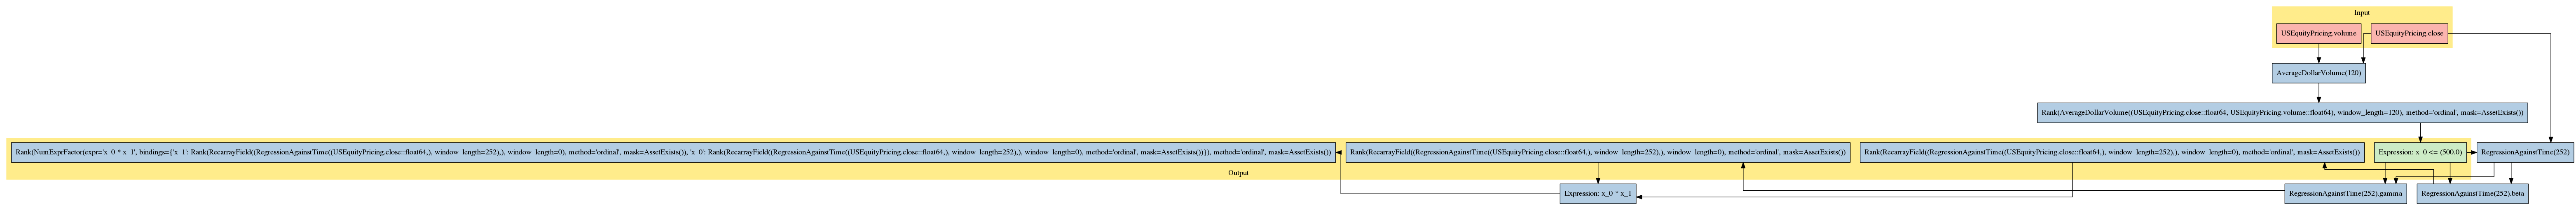

In [32]:
p.show_graph(format='png')

## run pipeline and view the factor data

In [33]:
df = engine.run_pipeline(p, factor_start_date, universe_end_date)

In [34]:
df.head()

conditional_factor  time_beta  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                  465.0      446.0   
                          Equity(1 [AAL])                219.0       88.0   
                          Equity(2 [AAP])                 72.0       31.0   
                          Equity(3 [AAPL])                14.0        7.0   
                          Equity(4 [ABBV])               385.0      308.0   

                                            time_gamma  
2014-01-03 00:00:00+00:00 Equity(0 [A])          388.0  
                          Equity(1 [AAL])        366.0  
                          Equity(2 [AAP])        456.0  
                          Equity(3 [AAPL])       462.0  
                          Equity(4 [ABBV])       210.0

## Visualize factor returns

These are returns that a theoretical portfolio would have if its stock weights were determined by a single alpha factor's values.

In [35]:
from quiz_helper import make_factor_plot

Formatting factor data for: conditional_factor
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: time_beta
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: time_gamma
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Time to get arrange factor data: 8.56 secs
Time to generate long/short returns: 1.17 secs


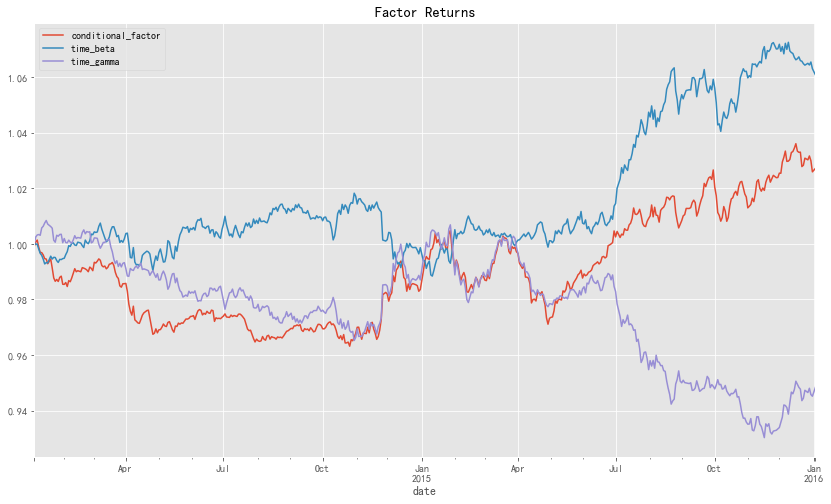

In [36]:
make_factor_plot(df, data_portal, trading_calendar, factor_start_date, universe_end_date);

## Solution
[The solution notebook is here](regression_against_time_solution.ipynb)